In [ ]:
# !pip install gensim polars
# !pip install fugashi[unidic]
# !python -m unidic download

# 整形処理
1. テキストデータの読み込み
2. 整形処理
3. 辞書・コーパスの作成

In [29]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)

In [22]:
import os
import polars as pl

# Load the livedoor news corpus
path_to_corpus = '../../text'  # 事前にDLして解凍が必要（https://www.rondhuit.com/download.html）
data = {}
cat, url, date, title, documents = [], [], [], [], []
for category in os.listdir(path_to_corpus):
    if category in ['CHANGES.txt', 'README.txt']:
        continue
    category_path = os.path.join(path_to_corpus, category)
    for file in os.listdir(category_path):
        if file in ['LICENSE.txt']:
            continue
        file_path = os.path.join(category_path, file)
        with open(file_path, 'r') as f:
            cat.append(category_path.split("/")[-1])
            url.append(f.readline())  # １行目：記事のURL
            date.append(f.readline())  # ２行目：記事の日付
            title.append(f.readline())  # ３行目：記事のタイトル
            documents.append(f.read())  # ４行目以降：記事の本文

df = pl.DataFrame({"CATEGORY": cat, "URL": url, "DATE": date, "TITLE": title, "DOCUMENT": documents})
df.write_csv("raw_corpus.csv")

In [1]:
import re
import requests
import polars as pl
from fugashi import Tagger
from gensim.corpora import Dictionary, MmCorpus
from gensim import models
from sklearn.model_selection import train_test_split

class LivedoorCorpus():
    def __init__(self, csv_path):
        self.df = pl.read_csv(csv_path)

        # 全角半角文字以外（記号と数字）を正規表現を使って除去
        pattern = r"[^\u3040-\u30ff\u3400-\u4dbf\u4e00-\u9fff\uf900-\ufaff\u20000-\u2ffff\sa-zA-Z]"
        self.raw_documents = [re.sub(pattern, "", text) for text in self.df["DOCUMENT"]]
        # Mecabで分かち書きして、単語に分割
        self.raw_documents = [Tagger('-Owakati').parse(text).split() for text in self.raw_documents]
        # ストップワードの除去
        self.raw_documents = self._rm_stopwords()
        # 1文字は除去
        self.raw_documents = [[word for word in text if len(word) > 1]for text in self.raw_documents]

        self.dictionary = Dictionary(self.raw_documents)

        self.bow = [ self.dictionary.doc2bow(text) for text in self.raw_documents]
    
    def reset_dict_corpus(self):
        self.dictionary = Dictionary(self.raw_documents)
        self.bow = [ self.dictionary.doc2bow(text) for text in self.raw_documents]

    def print_stats(self):
        print(f"文書数: {self.dictionary.num_docs}, " + f"語彙数: {len(self.dictionary)}")

    def dict_top_n(self, top_n: int):
        most_frequent_ids = (v for v in self.dictionary)
        most_frequent_ids = sorted(most_frequent_ids, key=self.dictionary.dfs.get, reverse=True)
        most_frequent_ids = most_frequent_ids[:top_n]
        return [self.dictionary[idx] for idx in most_frequent_ids]
        
    def _rm_stopwords(self):
        # ストップワードの準備
        stopwords_url = "http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt"
        r = requests.get(stopwords_url)
        tmp = r.text.split('\r\n')
        stopwords = []
        for i in range(len(tmp)):
            if len(tmp[i]) < 1:
                continue
            stopwords.append(tmp[i])

        return [[word for word in text if not word in stopwords]for text in self.raw_documents]


corpus = LivedoorCorpus('./raw_corpus.csv')

In [3]:
# 辞書サイズの調整を行なってください。
# 10個以上の文書に出現している単語、全文書に対して出現した文書が50%以下の単語に絞り込んでください。
# 該当箇所はコメントアウトしています。
# 日本語の解説：https://qiita.com/tatsuya-miyamoto/items/f505dfa8d5307f8c6e98#filter_extremesno_below5-no_above05-keep_n100000-keep_tokensnone

corpus.reset_dict_corpus()
corpus.print_stats()
# ここに辞書サイズを変える処理を書いてください。
corpus.print_stats()  # 「文書数: 7367, 語彙数: 13661」が表示されるはずです
bow = [ corpus.dictionary.doc2bow(text) for text in corpus.raw_documents]
doc_train, doc_test = train_test_split(bow, test_size=0.2)


文書数: 7367, 語彙数: 71140
文書数: 7367, 語彙数: 13661


# トピックモデル（LDA）の学習
- トピック数がハイパーパラメタです。
- トピック数が2~6個であるモデルをそれぞれ学習させます
- 上記のモデルで指標が最も良いモデルを選びます。

モデルの指標はパープレキシティといい、予測単語の候補数（どれだけ絞り込めているか）を表します。低い方が良い指標です。

In [4]:
topic_range = range(2, 3)

def calc_perplexity(m, c):
    import numpy as np
    return np.exp(-m.log_perplexity(c))

def search_model(corpus_train, corpus_test):
    most = [1.0e6, None]
    print(f"dataset: training/test = {len(corpus_train)}/{len(corpus_test)}")

    for t in topic_range:
        m = models.LdaModel(corpus=corpus_train, id2word=corpus.dictionary, num_topics=t, iterations=500, passes=5)
        p1 = calc_perplexity(m, corpus_train)
        p2 = calc_perplexity(m, corpus_test)
        print(f"{t}: perplexity is {p1}/{p2}")
        
        if p2 < most[0]:
            most[0] = p2
            most[1] = m
    
    return most[0], most[1]

perplexity, model = search_model(doc_train, doc_test)
print(f"Best model: topics={model.num_topics}, perplexity={perplexity}")

dataset: training/test = 5893/1474
2: perplexity is 3500.0975431890574/4092.4621459862215
3: perplexity is 3251.694018740017/4001.990060490945
4: perplexity is 3093.671215234207/3993.2988006754194
5: perplexity is 2965.5192783557736/3995.6631297669073
6: perplexity is 2890.4065646142635/4035.1339446259585
7: perplexity is 2944.14870226037/4227.005858783806
8: perplexity is 2890.9204962767226/4303.130728447653
9: perplexity is 2812.8672829266006/4226.474872533689
Best model: topics=4, perplexity=3993.2988006754194


### トピック間の距離
トピックは単語分布で表現されます。
確率分布であるので、KLダイバージェンスによって距離を測ることができます。

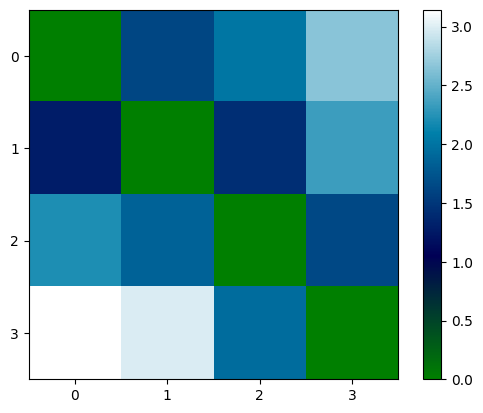

In [5]:
import numpy as np
import matplotlib.pylab as plt

def calc_topic_distances(m, topic):
    
    def kldiv(p, q):
        distance = np.sum(p * np.log(p / q))
        return distance
    
    # get probability of each words
    # https://github.com/piskvorky/gensim/blob/develop/gensim/models/ldamodel.py#L733
    t = m.state.get_lambda()
    for i, p in enumerate(t):
        t[i] = t[i] / t[i].sum()

    base = t[topic]
    distances = [(i_p[0], kldiv(base, i_p[1])) for i_p in enumerate(t) if i_p[0] != topic]
    return distances

def plot_distance_matrix(m):
    
    # make distance matrix
    mt = []
    for i in range(m.num_topics):
        d = calc_topic_distances(m, i)
        d.insert(i, (i, 0))  # distance between same topic
        d = [_d[1] for _d in d]
        mt.append(d)

    mt = np.array(mt)
    
    # plot matrix
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_aspect("equal")
    plt.imshow(mt, interpolation="nearest", cmap=plt.cm.ocean)
    plt.yticks(range(mt.shape[0]))
    plt.xticks(range(mt.shape[1]))
    plt.colorbar()
    plt.show()

plot_distance_matrix(model)

### 文書ごとのトピックの分布
トピックモデルでは、文書内のトピックの割合を推定しています。それを可視化してみましょう。

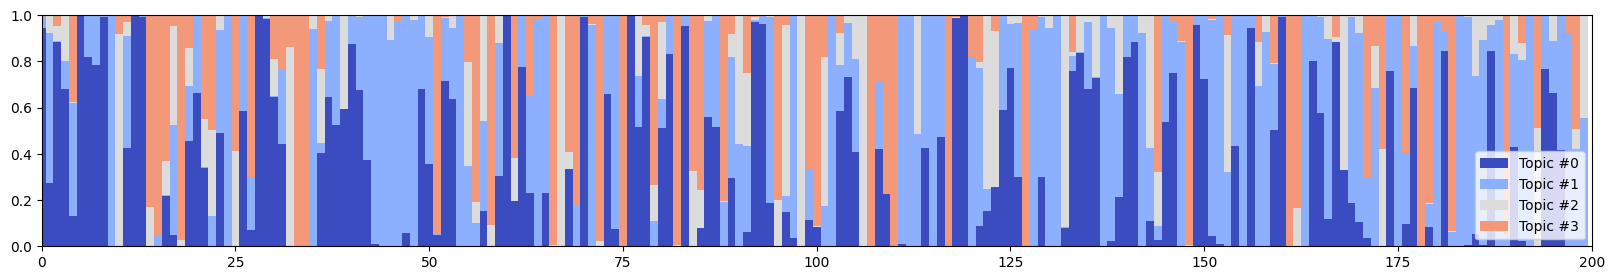

In [16]:
import random
import numpy as np
import matplotlib.pylab as plt

def show_document_topics(c, m, sample_size=200, width=1):

    # make document/topics matrix
    d_topics = []
    t_documents = {}
    samples = random.sample(range(len(c)), sample_size)
    for s in samples:
        ts = m.__getitem__(c[s], -1)
        d_topics.append([v[1] for v in ts])
        max_topic = max(ts, key=lambda x: x[1])
        if max_topic[0] not in t_documents:
            t_documents[max_topic[0]] = []
        t_documents[max_topic[0]] += [(s, max_topic[1])]
    
    d_topics = np.array(d_topics)
    
    for t in t_documents:
        t_documents[t] = sorted(t_documents[t], key=lambda x: x[1], reverse=True)
    
    # draw cumulative bar chart
    fig = plt.figure(figsize=(20, 3))
    N, K = d_topics.shape
    indices = np.arange(N)
    height = np.zeros(N)
    bar = []
    for k in range(K):
        color = plt.cm.coolwarm(k / K, 1)
        p = plt.bar(indices, d_topics[:, k], width, bottom=None if k == 0 else height, color=color)
        height += d_topics[:, k]
        bar.append(p)
    
    plt.ylim((0, 1))
    plt.xlim((0, d_topics.shape[0]))
    topic_labels = ['Topic #{}'.format(k) for k in range(K)]
    plt.legend([b[0] for b in bar], topic_labels)
    plt.show(bar)
    
    return d_topics, t_documents
    
document_topics, topic_documents = show_document_topics(doc_train, model)

### WordCloudによる可視化
実際にトピックがどんな単語で構成されているか、人間にわかりやすく可視化してみましょう。

ここでは、WordCloudという可視化で、単語の確率を重みとして大きさに反映させています。

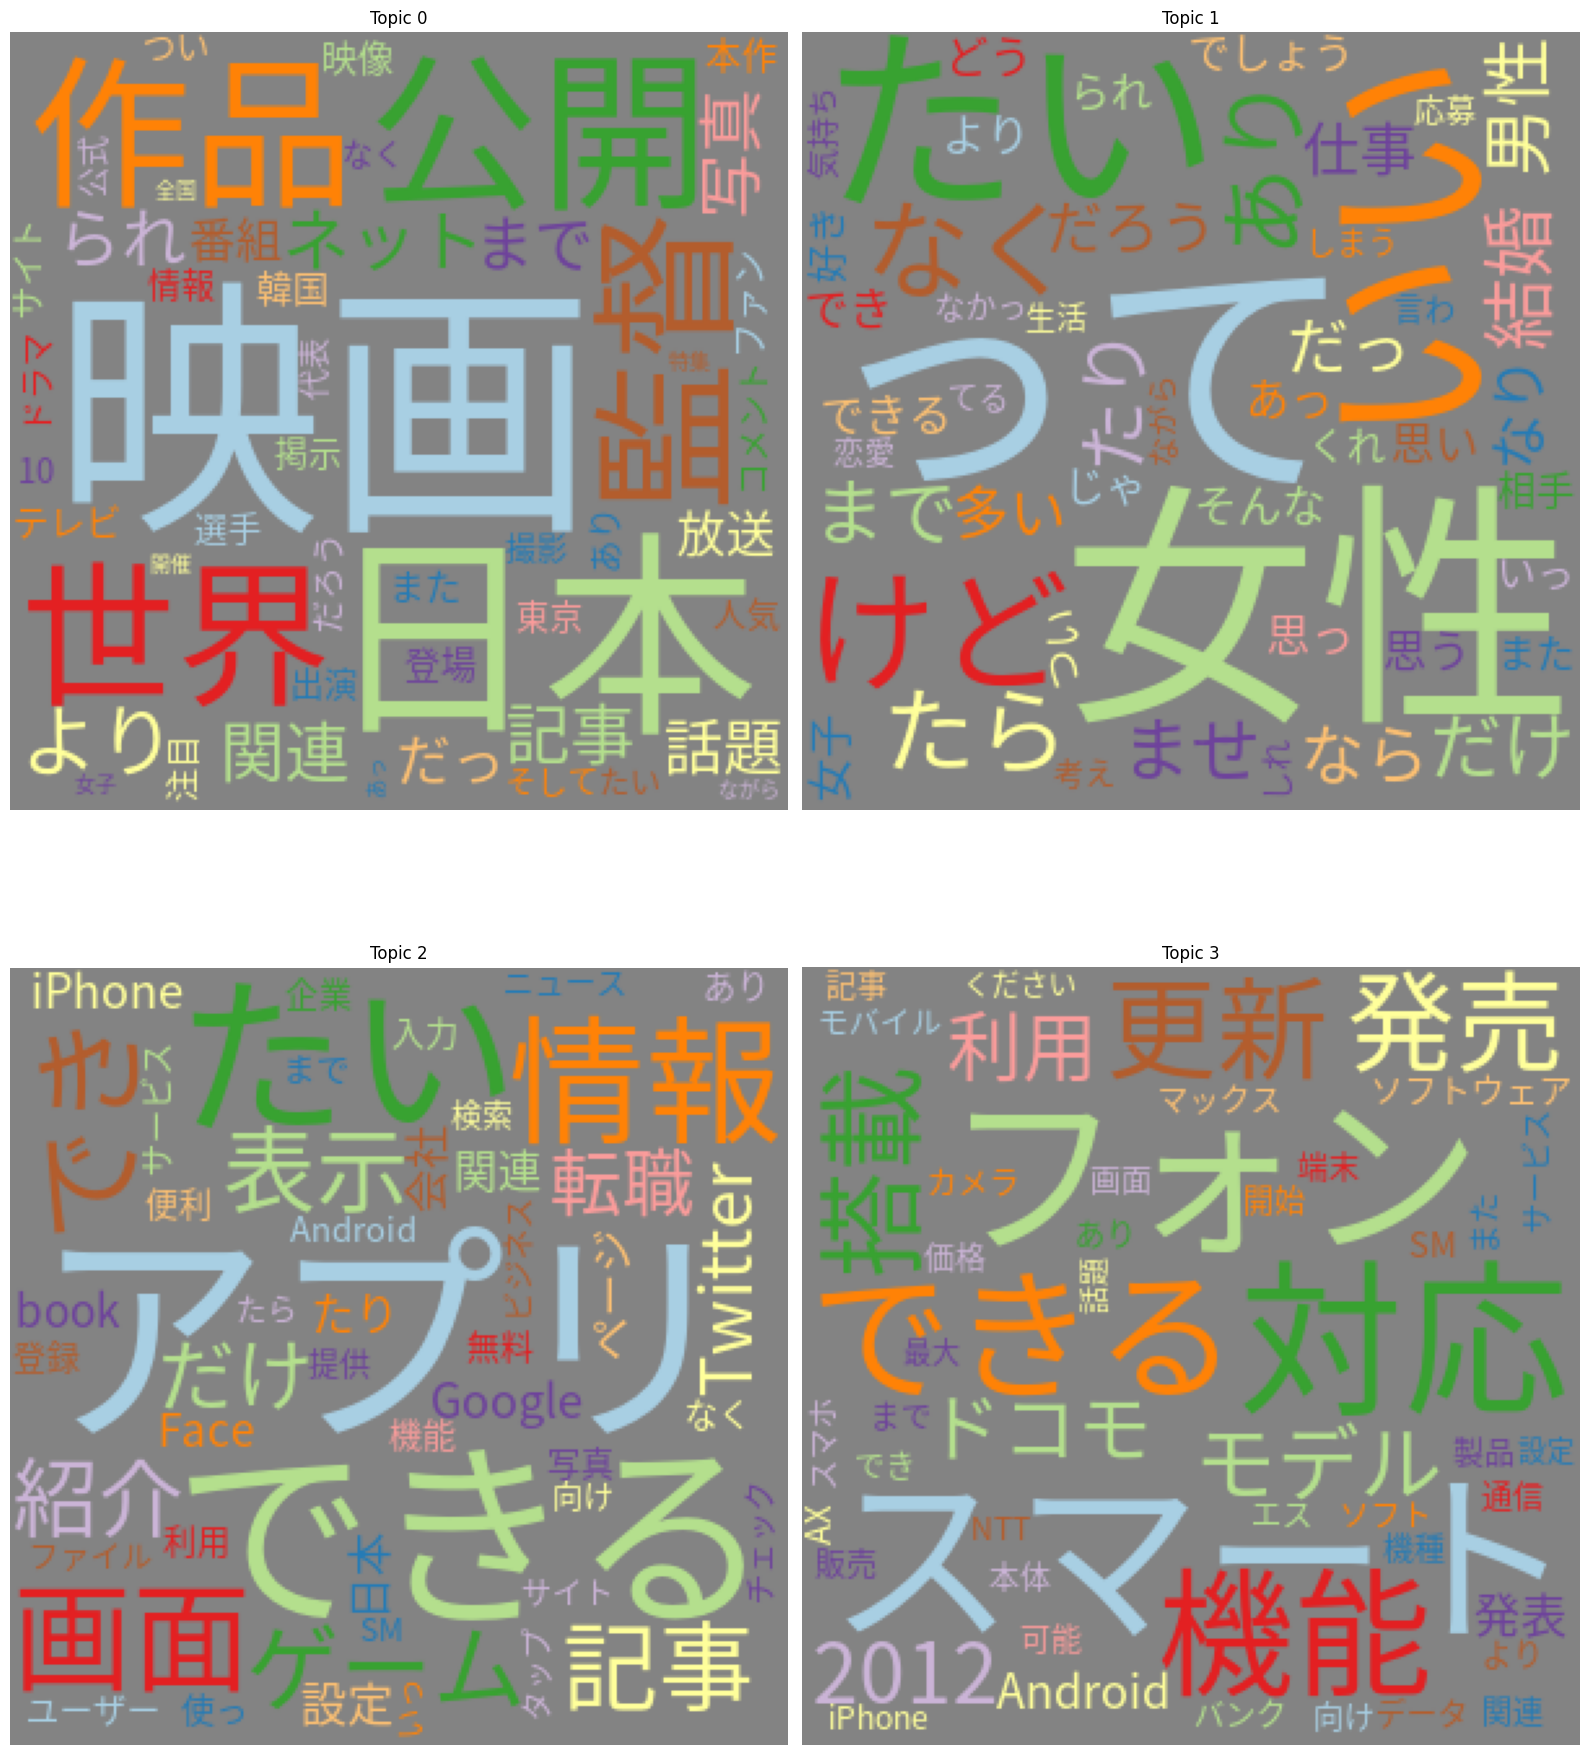

In [15]:
import matplotlib.pylab as plt
import math
from wordcloud import WordCloud

fig, axs = plt.subplots(ncols=2, nrows=math.ceil(model.num_topics/2), figsize=(16,20))
axs = axs.flatten()

def color_func(word, font_size, position, orientation, random_state, font_path):
    return 'darkturquoise'

for i, t in enumerate(range(model.num_topics)):

    x = dict(model.show_topic(t, 50))
    im = WordCloud(
        background_color='gray',
        color_func=color_func,
        font_path='../../NotoSansJP-Regular.otf',
        max_words=4000,
        width=300, height=300,
        random_state=0
    ).generate_from_frequencies(x)
    axs[i].imshow(im.recolor(colormap= 'Paired_r' , random_state=244), alpha=0.98)
    axs[i].axis('off')
    axs[i].set_title('Topic '+str(t))

# vis
plt.tight_layout()
plt.show()

# word2vecの学習
- BoWは使いません。
- ```__iter__```を定義したオブジェクトを使います。1文が```list[str]```で表現されています。
- 辞書は内部で作成してくれます。
- ```min_count=1```は少なくとも１回は出現している単語に制限するオプションです。

In [7]:
class WVCorpus():
    def __init__(self, corpus):
        self.corpus = corpus
    def __iter__(self):
        return iter(self.corpus)

sentences = WVCorpus(corpus.raw_documents)
# instantiating and training the Word2Vec model
model_wv = models.Word2Vec(
    sentences,
    min_count=1,
    compute_loss=True,
    hs=0,
    sg=1,
    seed=42,
)

# getting the training loss value
training_loss = model_wv .get_latest_training_loss()
print(training_loss)

29885452.0


### 最も類似している単語を抽出

In [8]:
model_wv .wv.most_similar('合コン')

[('意中', 0.7704073786735535),
 ('飲み会', 0.7674819231033325),
 ('座談', 0.7421150207519531),
 ('デート', 0.7410514950752258),
 ('知り合っ', 0.7379576563835144),
 ('誘い', 0.7289105653762817),
 ('ナンパ', 0.721918523311615),
 ('同席', 0.7218007445335388),
 ('ホンネ', 0.7160401940345764),
 ('パーティー', 0.715960681438446)]

### word2vecの辞書

In [9]:
for index, word in enumerate(model_wv .wv.index_to_key):
    if index == 10:
        break
    print(f"word #{index}/{len(model_wv .wv.index_to_key)} is {word}")

word #0/71140 is する
word #1/71140 is いる
word #2/71140 is ない
word #3/71140 is ます
word #4/71140 is です
word #5/71140 is いう
word #6/71140 is ある
word #7/71140 is なっ
word #8/71140 is その
word #9/71140 is なる


### 単語間の類似度を計算

In [10]:
pairs = [
    ('iPhone', 'Android'),
    ('iPhone', '新聞'),
    ('iPhone', 'パソコン'),
    ('iPhone', '時計'),
]
for w1, w2 in pairs:
    print(f"{w1}, {w2}, {model_wv .wv.similarity(w1, w2)}")

iPhone, Android, 0.4983060956001282
iPhone, 新聞, 0.33849021792411804
iPhone, パソコン, 0.44316959381103516
iPhone, 時計, 0.37384939193725586


### その他

In [11]:
# 新聞に似ている単語トップ５
print(model_wv .wv.most_similar(positive=['新聞'], topn=5))
# 新聞かニュースかに似ている単語トップ５
print(model_wv .wv.most_similar(positive=['新聞', 'ニュース'], topn=5))
# 次のリストの中で仲間はずれはどれでしょう？
print(model_wv .wv.doesnt_match(['新聞', '産経', '読売', '日経', '毎日', '今週']))

[('産経', 0.7998870015144348), ('虚構', 0.7721276879310608), ('読売', 0.7417054176330566), ('朝刊', 0.7298398017883301), ('市内', 0.7274710536003113)]
[('産経', 0.8146253228187561), ('虚構', 0.7771692872047424), ('報じる', 0.7360865473747253), ('市内', 0.7290983200073242), ('朝刊', 0.7125142812728882)]
今週
